In [1]:
import os
import glob
import mne
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy
from fooof import FOOOF, FOOOFGroup, fit_fooof_3d
from fooof.sim.gen import gen_aperiodic
import json

/tmp/ipykernel_28062/1207983033.py:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup, fit_fooof_3d


In [2]:
c3_chans=['E30','E36','E41','E31','E37','E42','E54','E53']
c4_chans=['E105','E104','E103','E80','E87','E93','E79','E86']
c_chans=[]
c_chans.extend(c3_chans)
c_chans.extend(c4_chans)

In [3]:
def compute_psds(age):
    subjects=[os.path.split(x)[-1] for x in glob.glob('/home/common/bonaiuto/devmobeta/data/sub-*')]
    subject_age_path=os.path.join('/home/common/bonaiuto/devmobeta/derivatives/')
    subject_age= os.path.join(subject_age_path,'participants_v2.csv')

    sub_psds=[]
    freqs=None
            
    with open(subject_age, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            print("Processing row:", row)
            subject=row['subject_id']
            session=row['session']
            subject_age = row['age']
            print("Subject:", subject, "Age:", subject_age)
            
            if subject_age==age:
                print(f"Processing subject {subject} with age {subject_age}")
                sub_path=os.path.join('/home/common/bonaiuto/devmobeta/derivatives/',subject)
                ses_path=os.path.join(sub_path, session)
                print(ses_path)
                if os.path.exists(os.path.join(ses_path,'eeg','NEARICA_NF')): 
                    print(f"Processing subject {subject} with age {subject_age}and session{session}")
                    eeg_path=os.path.join(ses_path,'eeg','NEARICA_NF')
                    fname=os.path.join(eeg_path, f'03_ica_data/{subject}_task-devmobeta_grasp_eeg_ica_art_rej_interp_reref.set')
                    if os.path.exists(fname):
                        raw_data=mne.io.read_raw_eeglab(fname, preload=True)
                        srate=raw_data.info['sfreq']

                        c_chan_idx=[]
                        for chan in c_chans:
                            if chan in raw_data.info['ch_names']:
                                c_chan_idx.append(raw_data.info['ch_names'].index(chan))
                        c_chan_idx=np.array(c_chan_idx)
                        
                        if len(c_chan_idx)==len(c_chans):
            
                            data=raw_data.get_data()
                            n_chans=data.shape[0]
                            n_samps=data.shape[1]

                            # Use a window size of 1s with a 50% overlap
                            winsize=srate
                            overlap=int(winsize/2)    

                            chan_data=data[c_chan_idx,:]
                            freqs, chan_psd=scipy.signal.welch(
                                chan_data, 
                                fs=srate, 
                                window='hann', 
                                nperseg=winsize, 
                                noverlap=overlap, 
                                nfft=int(winsize*20),
                                detrend='constant',
                                return_onesided=True, 
                                scaling='density', 
                                axis=- 1, 
                                average='mean'
                            )
                            f_idx=(freqs<=40)
                            freqs=freqs[f_idx]
                            chan_psd=chan_psd[:,f_idx]
                            sub_psds.append(chan_psd)
                else: 
                    print (f"Processing subject {subject} with age {subject_age} and {session} doesn't exist")
    sub_psds=np.array(sub_psds)
    file_path = f"psd_values_{age}.npz"  # Stocké localement dans l'environnement Jupyter
    
    # Sauvegarde des données dans un fichier NPZ
    np.savez(file_path, freqs=freqs, psds=sub_psds)
    
    print(f"PSD sauvegardée dans {file_path}")
    return freqs, sub_psds

In [4]:
freqs, sub_three_psds=compute_psds('three')
freqs, sub_six_psds=compute_psds('six')
freqs, sub_twelve_psds=compute_psds('twelve')

Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-201 Age: three
Processing subject sub-201 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-01
Processing subject sub-201 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: three
Processing subject sub-201 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-02
Processing subject sub-201 with age three and ses-02 doesn't exist
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: six
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-201 Age: six
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: twelve
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-06', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-201 Age: twelve


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: six
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: twelve
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: six
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-204 Age: twelve
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: twelve
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: six
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-205 Age: twelve
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: three
Processing subject sub-206 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-01
Processing subject sub-206 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-206 Age: three
Processing subject sub-206 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-02
Processing subject sub-206 with age threeand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-206 Age: six
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: twelve
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: three
Processing subject sub-207 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-02
Processing subject sub-207 with age threeand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: six
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: twelve
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-208 Age: three
Processing subject sub-208 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-01
Processing subject sub-208 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: three
Processing subject sub-208 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-02
Processing subject sub-208 with age threeand sessionses-02

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: six
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: twelve
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: three
Processing subject sub-209 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-01
Processing subject sub-209 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: six
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: twelve
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: three
Processing subject sub-210 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-01
Processing subject sub-210 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: six
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-211 Age: three
Processing subject sub-211 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-01
Processing subject sub-211 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-211 Age: six
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-211 Age: twelve
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-212 Age: three
Processing subject sub-212 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-01
Processing subject sub-212 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-212 Age: three
Processing subject sub-212 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-02
Processing subject sub-212 with age threeand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-212 Age: six
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-213 Age: three
Processing subject sub-213 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-01
Processing subject sub-213 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: three
Processing subject sub-213 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-02
Processing subject sub-213 with age three and ses-02 doesn't exist
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: six
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-213 Age: six
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: twelve
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-214 Age: three
Pr

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-215 Age: six
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-215 Age: twelve
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-216 Age: three
Processing subject sub-216 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-216/ses-01
Processing subject sub-216 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-216 Age: six
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-216 Age: twelve
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-217 Age: three
Processing subject sub-217 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-01
Processing subject sub-217 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-217 Age: six
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-217 Age: twelve
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: three
Processing subject sub-218 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-01
Processing subject sub-218 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: six
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'AB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: twelve
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: three
Processing subject sub-219 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-01
Processing subject sub-219 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: six
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: three
Processing subject sub-220 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-01
Processing subject sub-220 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: six
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: three
Processing subject sub-221 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-01
Processing subject sub-221 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-221 Age: three
Processing subject sub-221 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-02
Processing subject sub-221 with age threeand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-221 Age: six
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: six
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: twelve
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-222 Age: three
Processing subject sub-222 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-222/ses-01
Processing subject sub-222 with age threeand sessionses-01
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-222 Age: three
Processing

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-223 Age: six
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-223 Age: twelve
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-224 Age: three
Processing subject sub-224 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-02
Processing subject sub-224 with age threeand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-224 Age: six
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-224 Age: twelve
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-225 Age: three
Processing subject sub-225 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-01
Processing subject sub-225 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-225 Age: three
Processing subject sub-225 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-02
Processing subject sub-225 with age threeand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-225 Age: six
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-225 Age: twelve
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: three
Processing subject sub-226 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-01
Processing subject sub-226 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-226 Age: three
Processing subject sub-226 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-02
Processing subject sub-226 with age threeand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: six
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-226 Age: six
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: twelve
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-227 Age: three
Processing subject sub-227 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-227/ses-01
Processing subject sub-227 with age threeand sessionses-01
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-227 Age: six
Processi

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-229 Age: six
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-229 Age: twelve
Processing row: {'subject_id': 'sub-230', 'orig_participant_id': 'IM', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-230 Age: three
Processing subject sub-230 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-230/ses-01
Processing subject sub-230 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-230', 'orig_participant_id': 'IM', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-230 Age: six
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-231 Age: three
Processing subject sub-231 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-231/ses-01
Processing subject sub-231 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-231 Age: six
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-231 Age: twelve
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-232 Age: three
Processing subject sub-232 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-232/ses-01
Processing subject sub-232 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-232 Age: six
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-232 Age: twelve
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-233 Age: three
Processing subject sub-233 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-01
Processing subject sub-233 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-233 Age: six
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-233 Age: six
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: three
Processing subject sub-234 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-234/ses-01
Processing subject sub-234 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-234 Age: three
Processing subject sub-234 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-234/ses-02
Processing subject sub-234 with age threeand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: six
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: twelve
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-235 Age: three
Processing subject sub-235 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-235/ses-01
Processing subject sub-235 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-235 Age: six
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-235 Age: twelve
Processing row: {'subject_id': 'sub-236', 'orig_participant_id': 'ES', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-236 Age: three
Processing subject sub-236 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-236/ses-01
Processing subject sub-236 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-236', 'orig_participant_id': 'ES', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-236 Age: six
Processing row: {'subject_id': 'sub-236', 'orig_participant_id': 'ES', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-236 Age: twelve
Processing row: {'subject_id': 'sub-237', 'orig_participant_id': 'LMP', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-237 Age: three
Processing subject sub-237 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-237/ses-01
Processing subject sub-237 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-238 Age: three
Processing subject sub-238 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-238/ses-01
Processing subject sub-238 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-238 Age: three
Processing subject sub-238 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-238/ses-02
Processing subject sub-238 with age threeand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-238 Age: six
Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-238 Age: twelve
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: six
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-239 Age: six
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: twelve
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-240 Age: si

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: six
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: six
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: twelve
Processing row: {'subject_id': 'sub-242', 'orig_participant_id': 'LM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-242 Age: three
Processing subject sub-242 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-242/ses-01
Processing subject sub-242 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-242', 'orig_participant_id': 'LM', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-242 Age: six
Processing r

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-250 Age: six
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-251 Age: three
Processing subject sub-251 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-251/ses-01
Processing subject sub-251 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-251 Age: six
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-251 Age: twelve
Processing row: {'subject_id': 'sub-252', 'orig_participant_id': 'TE', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-2

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-253 Age: three
Processing subject sub-253 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-253/ses-01
Processing subject sub-253 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-253 Age: six
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: three
Processing subject sub-254 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-254/ses-01
Processing subject sub-254 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: six
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: three
Processing subject sub-255 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-255/ses-01
Processing subject sub-255 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: six
Processing row: {'subject_id': 'sub-256', 'orig_participant_id': 'AS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-256 Age: three
Processing subject sub-256 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-256/ses-01
Processing subject sub-256 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-257', 'orig_participant_id': 'CGM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-257 Age: three
Processing subject sub-257 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-257/ses-01
Processing subject sub-257 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-258 Age: three
Processing subject sub-258 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-258/ses-01
Processing subject sub-258 with age threeand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-258 Age: six
Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-259 Age: six
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-260 Age: three
Processing subject sub-260 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-260/ses-01
Processing subject sub-260 with age threeand sessionses-01
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-260 Age: six
Processing row: {'subject_id': 'sub-261', 'orig_participant_id': 'ML', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVisi

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: three
Processing subject sub-262 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-262/ses-01
Processing subject sub-262 with age threeand sessionses-01
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: six
Processing row: {'subject_id': 'sub-263', 'orig_participant_id': 'EOG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-263 Age: three
Processing subject sub-263 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-263/ses-01
Processing subject sub-263 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subjec

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, pr

Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-265 Age: three
Processing subject sub-265 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-265/ses-01
Processing subject sub-265 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-270 Age: three
Processing subject sub-270 with age three
/home/common/bonaiuto/devmobeta/derivatives/sub-270/ses-01
Processing subject sub-270 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-272 Age: six
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: twelve
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-06', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-201 Age: twelve
Processing row: {'subject_id': 'sub-202', 'orig_participant_id': 'RA', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-202 Age: six
Processing subject sub-202 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-202/ses-02
Processing subject sub-202 with age sixand sessionses-02
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: three
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: six
Proces

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: twelve
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: six
Processing subject sub-204 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-01
Processing subject sub-204 with age sixand sessionses-01


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-204 Age: twelve
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: twelve
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: three
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: six
Processing subject sub-205 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-02
Processing subject sub-205 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-205 Age: twelve
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: three
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-206 Age: three
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-206 Age: six
Processing subject sub-206 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-04
Processing subject sub-206 with age sixand sessionses-04


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: twelve
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: three
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: six
Processing subject sub-207 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-04
Processing subject sub-207 with age sixand sessionses-04


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: twelve
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-208 Age: three
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: three
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: six
Processing subject sub-208 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-03
Processing subject sub-208 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: twelve
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: three
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: six
Processing subject sub-209 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-03
Processing subject sub-209 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: twelve
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: three
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: six
Processing subject sub-210 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-03
Processing subject sub-210 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-211 Age: three
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-211 Age: six
Processing subject sub-211 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-03
Processing subject sub-211 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-211 Age: twelve
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-212 Age: three
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-212 Age: three
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-212 Age: six
Processing subject sub-212 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-03
Processing subject sub-212 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-213 Age: three
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: three
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: six
Processing subject sub-213 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-03
Processing subject sub-213 with age six and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-213 Age: six
Processing subject sub-213 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-04
Processing subject sub-213 with age sixand sessionses-04


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: twelve
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-214 Age: three
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-214 Age: three
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-214 Age: six
Processing subject sub-214 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-214/ses-03
Processing subject sub-214 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-214 Age: twelve
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-215 Age: three
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-215 Age: six
Processing subject sub-215 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-215/ses-03
Processing subject sub-215 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-215 Age: twelve
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-216 Age: three
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-216 Age: six
Processing subject sub-216 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-216/ses-03
Processing subject sub-216 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-216 Age: twelve
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-217 Age: three
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-217 Age: six
Processing subject sub-217 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-03
Processing subject sub-217 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-217 Age: twelve
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: three
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: six
Processing subject sub-218 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-02
Processing subject sub-218 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'AB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: twelve
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: three
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: six
Processing subject sub-219 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-02
Processing subject sub-219 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: three
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: six
Processing subject sub-220 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-03
Processing subject sub-220 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: three
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-221 Age: three
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-221 Age: six
Processing subject sub-221 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-03
Processing subject sub-221 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: six
Processing subject sub-221 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-04
Processing subject sub-221 with age six and ses-04 doesn't exist
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: twelve
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-222 Age: three
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-222 Age: three
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-222 Age: six
Proces

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-222 Age: twelve
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-223 Age: three
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-223 Age: three
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-223 Age: six
Processing subject sub-223 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-223/ses-04
Processing subject sub-223 with age sixand sessionses-04


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-223 Age: twelve
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-224 Age: three
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-224 Age: six
Processing subject sub-224 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-03
Processing subject sub-224 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-224 Age: twelve
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-225 Age: three
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-225 Age: three
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-225 Age: six
Processing subject sub-225 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-03
Processing subject sub-225 with age sixand sessionses-03


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-225 Age: twelve
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: three
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-226 Age: three
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: six
Processing subject sub-226 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-03
Processing subject sub-226 with age six and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-226 Age: six
Pr

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: twelve
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-227 Age: three
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-227 Age: six
Processing subject sub-227 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-227/ses-02
Processing subject sub-227 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-227 Age: twelve
Processing row: {'subject_id': 'sub-228', 'orig_participant_id': 'AFW', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-228 Age: three
Processing row: {'subject_id': 'sub-228', 'orig_participant_id': 'AFW', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-228 Age: three
Processing row: {'subject_id': 'sub-228', 'orig_participant_id': 'AFW', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-228 Age: twelve
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-229 Age: three
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-229 Ag

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-231 Age: three
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-231 Age: six
Processing subject sub-231 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-231/ses-02
Processing subject sub-231 with age six and ses-02 doesn't exist
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-231 Age: twelve
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-232 Age: three
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-232 Age: six
Pro

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-232 Age: twelve
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-233 Age: three
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-233 Age: six
Processing subject sub-233 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-03
Processing subject sub-233 with age six and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-233 Age: six
Processing subject sub-233 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-04
Processing subject sub-233 with age sixand sessionses-04


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: three
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-234 Age: three
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: six
Processing subject sub-234 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-234/ses-04
Processing subject sub-234 with age six and ses-04 doesn't exist
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: twelve
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-235 Age: three
Pr

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: twelve
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-240 Age: six
Processing subject sub-240 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-240/ses-01
Processing subject sub-240 with age six and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-240 Age: six
Processing subject sub-240 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-240/ses-02
Processing subject sub-240 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-240 Age: twelve
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-241 Age: three
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: six
Processing subject sub-241 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-241/ses-02
Processing subject sub-241 with age six and ses-02 doesn't exist
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: six
Processing subject sub-241 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-241/ses-04
Processing subject sub-241 with age six and ses-04 doesn't exist
Processing

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'bou

Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: three
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: six
Processing subject sub-254 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-254/ses-02
Processing subject sub-254 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: three
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: six
Processing subject sub-255 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-255/ses-02
Processing subject sub-255 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-256', 'orig_participant_id': 'AS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-256 Age: three
Processing row: {'subject_id': 'sub-257', 'orig_participant_id': 'CGM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-257 Age: three
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-258 Age: three
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-258 Age: six
Processing subject sub-258 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-258/ses-02
Processing subject sub-258 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-259 Age: six
Processing subject sub-259 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-259/ses-01
Processing subject sub-259 with age sixand sessionses-01
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-260 Age: three
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-260 Age: six
Processing subject sub-260 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-260/ses-02
Processing subject sub-260 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-261', 'orig_participant_id': 'ML', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-261 Age: three
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: three
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: six
Processing subject sub-262 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-262/ses-02
Processing subject sub-262 with age sixand sessionses-02


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-263', 'orig_participant_id': 'EOG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-263 Age: three
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-264 Age: three
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-265 Age: three
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-270 Age: three
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-272 Age: six
Processing subject sub-272 with age six
/home/common/bonaiuto/devmobeta/derivatives/sub-272/ses-01
Processing subject sub-272 with age sixa

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-202', 'orig_participant_id': 'RA', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-202 Age: six
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: three
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: six
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: twelve
Processing subject sub-203 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-203/ses-05
Processing subject sub-203 with age twelveand sessionses-05


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: six
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-204 Age: twelve
Processing subject sub-204 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-03
Processing subject sub-204 with age twelve and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: twelve
Processing subject sub-204 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-04
Processing subject sub-204 with age twelveand sessionses-04


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: three
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: six
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-205 Age: twelve
Processing subject sub-205 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-03
Processing subject sub-205 with age twelve and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: three
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-206 Age:

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-208 Age: three
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: three
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: six
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: twelve
Processing subject sub-208 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-05
Processing subject sub-208 with age twelveand sessionses-05


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: three
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: six
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: twelve
Processing subject sub-209 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-05
Processing subject sub-209 with age twelveand sessionses-05


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: three
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: six
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing subject sub-210 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-04
Processing subject sub-210 with age twelve and ses-04 doesn't exist
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing subject sub-210 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-05
Processing subject sub-210 with age twelve and ses-05 

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: three
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: six
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: three
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: six
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: three
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-221 Age: t

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'bou

Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: six
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-239 Age: six
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: twelve
Processing subject sub-239 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-239/ses-03
Processing subject sub-239 with age twelve and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-240 Age: six
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-240 Age: six
Pro

/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-246', 'orig_participant_id': 'LMD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-246 Age: three
Processing row: {'subject_id': 'sub-246', 'orig_participant_id': 'LMD', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-246 Age: six
Processing row: {'subject_id': 'sub-246', 'orig_participant_id': 'LMD', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-246 Age: twelve
Processing subject sub-246 with age twelve
/home/common/bonaiuto/devmobeta/derivatives/sub-246/ses-03
Processing subject sub-246 with age twelveand sessionses-03
Processing row: {'subject_id': 'sub-247', 'orig_participant_id': 'AR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-247 Age: three
Processing row: {'subject_id': 'sub-247', 'orig_participant_id': 'AR', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-247 Age: six


/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_28062/1112436020.py:28: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


In [5]:
print(f'N 3m: {sub_three_psds.shape[0]}')
print(f'N 6m: {sub_six_psds.shape[0]}')
print(f'N 12m: {sub_twelve_psds.shape[0]}')

N 3m: 33
N 6m: 31
N 12m: 7


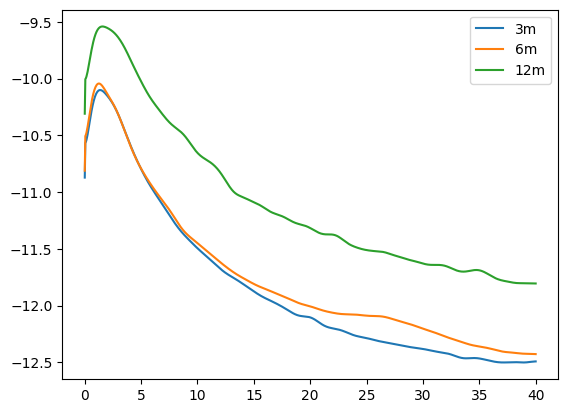

In [6]:
plt.plot(freqs,np.log10(np.mean(np.mean(sub_three_psds,axis=1),axis=0)),label='3m')
plt.plot(freqs,np.log10(np.mean(np.mean(sub_six_psds,axis=1),axis=0)),label='6m')
plt.plot(freqs,np.log10(np.mean(np.mean(sub_twelve_psds,axis=1),axis=0)),label='12m')
plt.legend()

In [7]:
def parameterize_psds(freqs, sub_psds):
    n_chans=sub_psds.shape[1]
    fg = FOOOFGroup()
    fgs=fit_fooof_3d(fg, freqs, sub_psds, [.05, 40])
    
    sub_periodic=np.zeros(sub_psds.shape)
    sub_aperiodic=np.zeros(sub_psds.shape)
    for s_idx, fg in enumerate(fgs):
        for chan in range(n_chans):
            if chan in fg.null_inds_:
                sub_aperiodic[s_idx,chan,:]=float('NaN')
                sub_periodic[s_idx,chan,:]=float('NaN')
            else:
                fm = fg.get_fooof(ind=chan, regenerate=True)
                ap_params=fm.get_params('aperiodic_params')
                sub_aperiodic[s_idx,chan,:] = gen_aperiodic(freqs, ap_params)
                sub_periodic[s_idx,chan,:]=np.log10(sub_psds[s_idx,chan,:])-sub_aperiodic[s_idx,chan,:]
    return fgs, sub_periodic, sub_aperiodic

In [8]:
fgs_3m, sub_three_periodic, sub_three_aperiodic=parameterize_psds(freqs, sub_three_psds)
fgs_6m, sub_six_periodic, sub_six_aperiodic=parameterize_psds(freqs, sub_six_psds)
fgs_12m, sub_twelve_periodic, sub_twelve_aperiodic=parameterize_psds(freqs, sub_twelve_psds)

Running FOOOFGroup across 528 power spectra.


/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


Running FOOOFGroup across 496 power spectra.


/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


Running FOOOFGroup across 112 power spectra.


/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


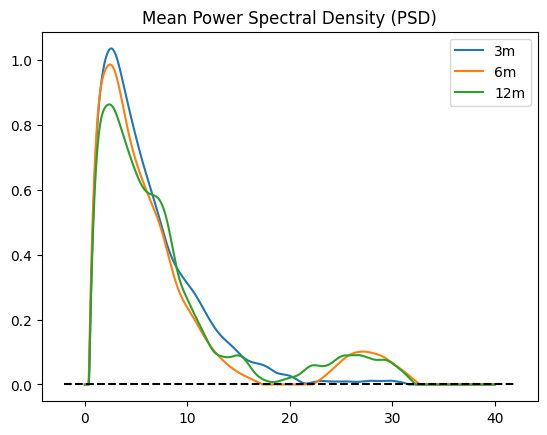

In [9]:
mean_psd_3m=np.mean(np.mean(sub_three_periodic,axis=1),axis=0)
mean_psd_3m[mean_psd_3m<0]=0
mean_psd_6m=np.mean(np.mean(sub_six_periodic,axis=1),axis=0)
mean_psd_6m[mean_psd_6m<0]=0
mean_psd_12m=np.mean(np.mean(sub_twelve_periodic,axis=1),axis=0)
mean_psd_12m[mean_psd_12m<0]=0

plt.plot(freqs,mean_psd_3m,label='3m')
plt.plot(freqs,mean_psd_6m,label='6m')
plt.plot(freqs,mean_psd_12m,label='12m')
plt.plot(plt.xlim(), [0, 0],'k--')
plt.title('Mean Power Spectral Density (PSD)')
plt.legend()

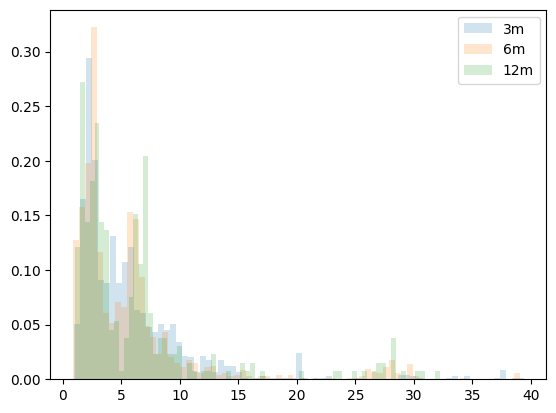

In [10]:
all_peaks_3m=[]
all_peaks_6m=[]
all_peaks_12m=[]
for s_idx, fg in enumerate(fgs_3m):
    for chan in range(len(c_chans)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_3m.extend(peaks)
        else:
            all_peaks_3m.append(peaks)
for s_idx, fg in enumerate(fgs_6m):
    for chan in range(len(c_chans)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_6m.extend(peaks)
        else:
            all_peaks_6m.append(peaks)
for s_idx, fg in enumerate(fgs_12m):
    for chan in range(len(c_chans)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_12m.extend(peaks)
        else:
            all_peaks_12m.append(peaks)
plt.hist(all_peaks_3m,75,alpha=.2,density=True,label='3m')
plt.hist(all_peaks_6m,75,alpha=.2,density=True,label='6m')
plt.hist(all_peaks_12m,75,alpha=.2,density=True,label='12m')
plt.legend()

In [32]:
def define_fois(freqs, mean_psd, age, debug=False):
    mean_resid=mean_psd
    foi_pk_freqs=[]
    foi_pk_vals=[]    
    foi_fwhms=[]
    foi_ranges=[]
    foi_info = {} 
    foi_counter = 1  
    
    orig_pks,properties=scipy.signal.find_peaks(mean_resid)
    while True:
        pks,properties=scipy.signal.find_peaks(mean_resid)

        pk_vals=mean_resid[pks]
        sorted_idx=np.argsort(-pk_vals)
        pk_vals=pk_vals[sorted_idx]
        pks=pks[sorted_idx]

        pk_idx=pks[0]
        pk_val=pk_vals[0]
        pk_freq=freqs[pk_idx]
        
        if pk_val<np.std(mean_resid):
            if debug:
                print('Peak val={}, thresh={}'.format(pk_val,.5*np.std(mean_resid)))
            break
        
        l_idx=np.where(mean_resid[:pk_idx]<=pk_val*.5)[0]
        r_idx=np.where(mean_resid[pk_idx:]<=pk_val*.5)[0]

        if len(l_idx) and len(r_idx):
            l_freq=freqs[l_idx[-1]]
            r_freq=freqs[pk_idx+r_idx[0]]
            r_side=(r_freq-pk_freq)
            l_side=(pk_freq-l_freq)
            fwhm=2*np.min([r_side, l_side])
        elif len(l_idx):
            l_freq=freqs[l_idx[-1]]
            fwhm=2*(pk_freq-l_freq)
        elif len(r_idx):
            r_freq=freqs[pk_idx+r_idx[0]+1]
            fwhm=2*(r_freq-pk_freq)

        l_freq=pk_freq-fwhm*.5
        r_freq=pk_freq+fwhm*.5
        sd=fwhm/(2*np.sqrt(2*np.log(2)))
        A=pk_vals[0]*np.exp(-.5*((freqs-pk_freq)/sd)**2)
        nearest_orig=np.min(np.abs(freqs[np.array(orig_pks)]-pk_freq))
            
        if pk_val>np.std(mean_resid) and ((pk_freq<10 and fwhm>2) or (pk_freq>=10 and fwhm>2.4)):# and nearest_orig<3:
            print('Peak: freq={}, val={}, width={}, range={}-{}'.format(pk_freq, pk_val, fwhm, pk_freq-fwhm*.5, pk_freq+fwhm*.5))
            print('Distance to nearest original peak={}'.format(nearest_orig))
            if debug:
                plt.figure(figsize=(12,4))
                plt.subplot(1,2,1)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs[pks],mean_resid[pks],'ro')
                plt.subplot(1,2,2)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs,A)
            
            foi_pk_freqs.append(pk_freq)
            foi_pk_vals.append(pk_val)
            foi_fwhms.append(fwhm)
            foi_ranges.append([l_freq,r_freq])

            band_name = f'FOI_{foi_counter}'
            foi_info[band_name] = {'frequency_range': [l_freq, r_freq], 'peak_frequency': pk_freq}
            foi_counter += 1
            
        elif debug:
            if not ((pk_freq<10 and fwhm>2) or (pk_freq>=10 and fwhm>2.4)):
                print('Peak: freq={}, fhwm={} to narrow'.format(pk_freq, fwhm))
            if pk_val<=np.std(mean_resid):
                print('Peak: freq={} too low amplitude'.format(pk_freq))
            #if nearest_orig>=3:
            #    print('Peak: freq={} too far from original peaks'.format(pk_freq))

        mean_resid=mean_resid-A
        #mean_resid[mean_resid<0]=0
    sorted_idx=np.argsort(foi_pk_freqs)
    
    foi_pk_freqs=np.array(foi_pk_freqs)
    foi_pk_vals=np.array(foi_pk_vals)
    foi_fwhms=np.array(foi_fwhms)
    foi_ranges=np.array(foi_ranges)
    
    foi_pk_freqs=foi_pk_freqs[sorted_idx]
    foi_pk_vals=foi_pk_vals[sorted_idx]
    foi_fwhms=foi_fwhms[sorted_idx]
    foi_ranges=foi_ranges[sorted_idx,:]

    with open(f'frequency_ranges_{age}_EGI.json', 'w') as json_file:
        json.dump(foi_info, json_file)
    
    plt.figure()
    plt.plot(freqs,mean_psd, label='Mean PSD')
    for f_idx in range(foi_ranges.shape[0]):
        sd=foi_fwhms[f_idx]/(2*np.sqrt(2*np.log(2)))
        A=foi_pk_vals[f_idx]*np.exp(-.5*((freqs-foi_pk_freqs[f_idx])/sd)**2)
        plt.plot(freqs,A)
        plt.title(f'Peak Detection for {age} months')
    
    return foi_info, foi_pk_freqs,foi_pk_vals,foi_fwhms,foi_ranges

Peak: freq=2.6, val=1.0343832168318454, width=3.6, range=0.8-4.4
Distance to nearest original peak=0.0
Peak: freq=6.2, val=0.5620139509175526, width=3.9000000000000004, range=4.25-8.15
Distance to nearest original peak=3.6
Peak: freq=10.25, val=0.27279221620225935, width=4.300000000000001, range=8.1-12.4
Distance to nearest original peak=7.65
Peak: freq=14.25, val=0.09698135497568224, width=3.8999999999999986, range=12.3-16.2
Distance to nearest original peak=8.850000000000001
Peak: freq=17.6, val=0.04469001035903022, width=2.700000000000003, range=16.25-18.950000000000003
Distance to nearest original peak=5.5


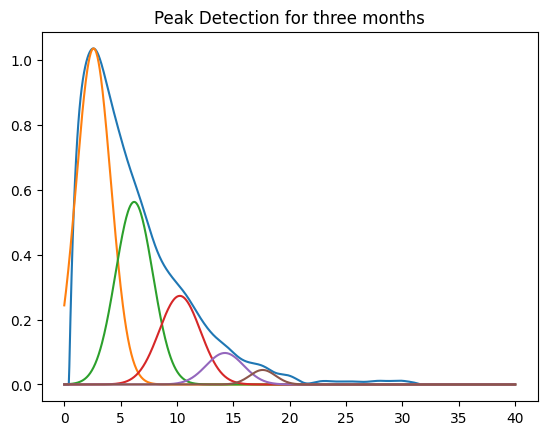

In [33]:
foi_info_3m, foi_pk_freqs_3m,foi_pk_vals_3m,foi_fwhms_3m,foi_ranges_3m=define_fois(freqs, mean_psd_3m, 'three', debug=False)

Peak: freq=2.45, val=0.985121748810677, width=3.4000000000000004, range=0.75-4.15
Distance to nearest original peak=0.0
Peak: freq=6.0, val=0.5501456287660333, width=3.9000000000000004, range=4.05-7.95
Distance to nearest original peak=3.55
Peak: freq=9.8, val=0.20798948992067393, width=4.700000000000001, range=7.45-12.150000000000002
Distance to nearest original peak=7.3500000000000005
Peak: freq=27.150000000000002, val=0.10126687441814303, width=5.800000000000004, range=24.25-30.050000000000004
Distance to nearest original peak=0.0


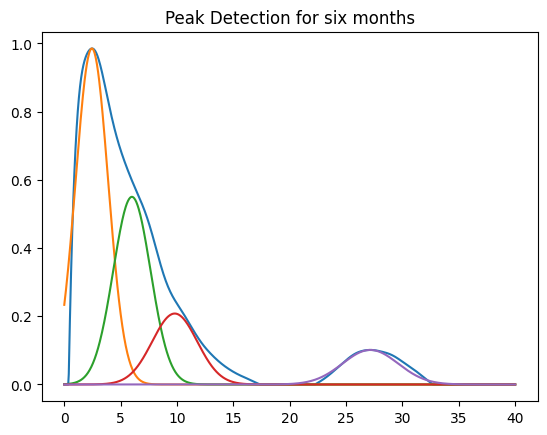

In [34]:
foi_info_6m, foi_pk_freqs_6m,foi_pk_vals_6m,foi_fwhms_6m,foi_ranges_6m=define_fois(freqs, mean_psd_6m, 'six', debug=False)

Peak: freq=2.4000000000000004, val=0.8621476248931478, width=3.3000000000000007, range=0.75-4.050000000000001
Distance to nearest original peak=0.0
Peak: freq=6.800000000000001, val=0.5753283661128438, width=5.700000000000001, range=3.95-9.650000000000002
Distance to nearest original peak=4.4
Peak: freq=26.55, val=0.09065092166130047, width=8.600000000000001, range=22.25-30.85
Distance to nearest original peak=0.0
Peak: freq=14.950000000000001, val=0.08697670890767592, width=2.8000000000000007, range=13.55-16.35
Distance to nearest original peak=0.05000000000000071
Peak: freq=11.55, val=0.07670416978001499, width=2.6000000000000014, range=10.25-12.850000000000001
Distance to nearest original peak=3.3499999999999996


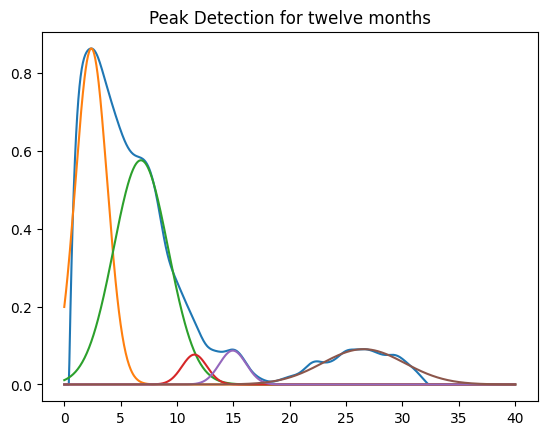

In [35]:
foi_info_12m,foi_pk_freqs_12m,foi_pk_vals_12m,foi_fwhms_12m,foi_ranges_12m=define_fois(freqs, mean_psd_12m, 'twelve', debug=False)

In [36]:
import scipy.io

fname = "processed_psd_three.mat"
output_path = fname  

scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_three_psds,
                     'periodic': sub_three_periodic,
                     'aperiodic': sub_three_aperiodic,
                     'foi_pk_freqs': foi_pk_freqs_3m,
                     'foi_pk_vals': foi_pk_vals_3m,
                     'foi_fwhms': foi_fwhms_3m,
                     'foi_ranges': foi_ranges_3m
                 })  

In [37]:
import scipy.io

fname = "processed_psd_six.mat"
output_path = fname  

scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_six_psds,
                     'periodic': sub_six_periodic,
                     'aperiodic': sub_six_aperiodic,
                     'foi_pk_freqs': foi_pk_freqs_6m,
                     'foi_pk_vals': foi_pk_vals_6m,
                     'foi_fwhms': foi_fwhms_6m,
                     'foi_ranges': foi_ranges_6m
                 })  

In [38]:
import scipy.io

fname = "processed_psd_twelve.mat"
output_path = fname  

scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_twelve_psds,
                     'periodic': sub_twelve_periodic,
                     'aperiodic': sub_twelve_aperiodic,
                     'foi_pk_freqs': foi_pk_freqs_12m,
                     'foi_pk_vals': foi_pk_vals_12m,
                     'foi_fwhms': foi_fwhms_12m,
                     'foi_ranges': foi_ranges_12m
                 })  

In [39]:
foi_ranges_3m

array([[ 0.8 ,  4.4 ],
       [ 4.25,  8.15],
       [ 8.1 , 12.4 ],
       [12.3 , 16.2 ],
       [16.25, 18.95]])

In [40]:
foi_ranges_6m

array([[ 0.75,  4.15],
       [ 4.05,  7.95],
       [ 7.45, 12.15],
       [24.25, 30.05]])

In [41]:
foi_ranges_12m

array([[ 0.75,  4.05],
       [ 3.95,  9.65],
       [10.25, 12.85],
       [13.55, 16.35],
       [22.25, 30.85]])